# tables 
# normal

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys
sys.path.append("..")
from modules.utils import paper_style
from sklearn.metrics import r2_score
from helper_fn import *
sys.path.append("..")
current_dir = ""
relative_path = "../data"
path = os.path.join(current_dir, relative_path)
data_path = os.path.join(path, "test/")
data_drug_path = os.path.join(path, "test_drug/")
gt_path = os.path.join(path, "GT/")
gt_drug_path = os.path.join(path, "GT_drug/labels/")

drug = False

if drug:
    data_path_ = data_drug_path
    gt_path_ = gt_drug_path
else:
    data_path_ = data_path
    gt_path_ = gt_path

gt_tracks = []
taus = []
for i, fn in enumerate(os.listdir(gt_path_)):
    track = np.load(os.path.join(gt_path_, fn)).squeeze().T
    tau = np.linspace(0, 1, track.shape[0])
    gt_tracks.append(track)
    taus.append(tau)
track_lengths = [track.shape[0] for track in gt_tracks]
modalities = ["bf", "h2b"]
data = {}
for mod in modalities:
    data[mod] = {}
    for head in heads:
        # loading the dataset
        tracks = get_data(data_path_, mod, head)
        data[mod][head] = tracks

good_heads = ["mlp", "cnn", "lstm", "xtransformer-causal", "mamba", "xtransformer"]
data['bf']['GT'] = gt_tracks
data['h2b']['GT'] = gt_tracks

In [2]:

import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
from dtaidistance import dtw
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
import itertools

columns = ['$L_{1, FUCCI_1}$', '$L_{1, FUCCI_2}$', '$R^2_{FUCCI_1}$', '$R^2_{FUCCI_2}$', '$L_1$', '$R^2$', '$DTW$', ]
super_columns = {'bf':"Brightfield", 'h2b': "Histone H2B"}
good_heads = ["mlp", "cnn", "lstm", "xtransformer-causal", "mamba", "xtransformer"]
models = {key:val for key, val in zip(good_heads, ['Single Frame', 'Causal CNN', 'LSTM', 'Causal Transformer', 'Mamba', 'Transformer'])}
rows = []
dtw_vals = pd.read_csv('df_metrics.csv')
dtw_std_vals = pd.read_csv('df_metrics_std.csv')
for mod in ['bf', 'h2b']:
    for head in good_heads:
        print(mod, head)
        l1_red_vals = [mean_absolute_error(data[mod][head][idx][:, 1], data[mod]['GT'][idx][:, 1]) for idx in range(len(gt_tracks))]
        l1_green_vals = [mean_absolute_error(data[mod][head][idx][:, 0], data[mod]['GT'][idx][:, 0]) for idx in range(len(gt_tracks))]
        r2_red_vals = [r2_score(gt_tracks[idx][:, 1], data[mod][head][idx][:, 1]) for idx in range(len(gt_tracks))]
        r2_green_vals = [r2_score(gt_tracks[idx][:, 0], data[mod][head][idx][:, 0]) for idx in range(len(gt_tracks))]
        l1_vals = [mean_absolute_error(data[mod][head][idx], data[mod]['GT'][idx]) for idx in range(len(gt_tracks))]
        r2_vals = [r2_score(gt_tracks[idx], data[mod][head][idx]) for idx in range(len(gt_tracks))]
        
        dtw_mean, dtw_std = dtw_vals[(dtw_vals['head'] == models[head]) & (dtw_vals['modality'] == mod)]['DTW'].values[0], dtw_std_vals[(dtw_std_vals['head'] == models[head]) & (dtw_std_vals['modality'] == mod)]['DTW_std'].values[0]
        rows.append([
            [np.mean(l1_red_vals), np.std(l1_red_vals)],
            [np.mean(l1_green_vals), np.std(l1_green_vals)],
            [np.mean(r2_red_vals), np.std(r2_red_vals)],
            [np.mean(r2_green_vals), np.std(r2_green_vals)],
            [np.mean(l1_vals), np.std(l1_vals)],
            [np.mean(r2_vals), np.std(r2_vals)],
            [dtw_mean, dtw_std]
        ])

rows_mean = [list(zip(*r))[0] for r in rows]
rows_std = [list(zip(*r))[1] for r in rows]

data_ = pd.concat([pd.DataFrame(rows_mean[:len(rows_mean)//2]), pd.DataFrame(rows_mean[len(rows_mean)//2:])], axis=1)
data_.columns = pd.MultiIndex.from_product([list(super_columns.values()), columns])
data_.index = list(models.values())

std_values = pd.concat([pd.DataFrame(rows_std[:len(rows_std)//2]), pd.DataFrame(rows_std[len(rows_std)//2:])], axis=1)
std_values.columns = pd.MultiIndex.from_product([list(super_columns.values()), columns])
std_values.index = list(models.values())

latex_df = data_.copy()
skip_std = False
for col in itertools.product(list(super_columns.values()), ['$L_1$', '$L_{1, FUCCI_1}$', '$L_{1, FUCCI_2}$', '$DTW$']):
    min_value = data_[col].min()
    min_std = std_values[col][data_[col] == min_value]
    latex_df[col] = data_[col].apply(lambda x: f"\\textbf{{{x:.3f}}}" if x == min_value else f"{x:.3f}")
    if not skip_std:
        latex_df[col] += std_values[col].apply(
            lambda s: f" \\textbf{{± {s:.3f}}}" if s in min_std.values else f" ± {s:.3f}"
        )

for col in itertools.product(list(super_columns.values()), ['$R^2_{FUCCI_1}$', '$R^2_{FUCCI_2}$', '$R^2$']):
    max_value = data_[col].max()
    max_std = std_values[col][data_[col] == max_value]
    latex_df[col] = data_[col].apply(lambda x: f"\\textbf{{{x:.3f}}}" if x == max_value else f"{x:.3f}")
    if not skip_std:
        latex_df[col] += std_values[col].apply(
            lambda s: f" \\textbf{{± {s:.3f}}}" if s in max_std.values else f" ± {s:.3f}"
        )

display(latex_df)
with open("table1.tex", "w") as f:
    f.write(latex_df.to_latex(index=True, escape=False))


bf mlp
bf cnn
bf lstm
bf xtransformer-causal
bf mamba
bf xtransformer
h2b mlp
h2b cnn
h2b lstm
h2b xtransformer-causal
h2b mamba
h2b xtransformer


Brightfield  \
                                   $L_{1, FUCCI_1}$   
Single Frame                          0.193 ± 0.066   
Causal CNN                            0.157 ± 0.078   
LSTM                                  0.108 ± 0.069   
Causal Transformer                    0.121 ± 0.073   
Mamba                                 0.112 ± 0.072   
Transformer         \textbf{0.066} \textbf{± 0.038}   

                                                     \
                                   $L_{1, FUCCI_2}$   
Single Frame                          0.146 ± 0.045   
Causal CNN                            0.122 ± 0.049   
LSTM                                  0.087 ± 0.047   
Causal Transformer                    0.094 ± 0.048   
Mamba                                 0.091 ± 0.049   
Transformer         \textbf{0.062} \textbf{± 0.037}   

                                                     \
                                    $R^2_{FUCCI_1}$   
Single Frame                          0.347 ± 0.352   
Causal CNN                            0.535 ± 0.406   
LSTM                                  0.686 ± 0.353   
Causal Transformer                    0.649 ± 0.362   
Mamba                                 0.673 ± 0.372   
Transformer         \textbf{0.880} \textbf{± 0.146}   

                                                     \
                                    $R^2_{FUCCI_2}$   
Single Frame                          0.571 ± 0.264   
Causal CNN                            0.680 ± 0.265   
LSTM                                  0.811 ± 0.246   
Causal Transformer                    0.791 ± 0.266   
Mamba                                 0.806 ± 0.254   
Transformer         \textbf{0.905} \textbf{± 0.136}   

                                                     \
                                              $L_1$   
Single Frame                          0.170 ± 0.049   
Causal CNN                            0.140 ± 0.056   
LSTM                                  0.097 ± 0.052   
Causal Transformer                    0.108 ± 0.055   
Mamba                                 0.102 ± 0.055   
Transformer         \textbf{0.064} \textbf{± 0.031}   

                                                     \
                                              $R^2$   
Single Frame                          0.459 ± 0.271   
Causal CNN                            0.608 ± 0.294   
LSTM                                  0.749 ± 0.266   
Causal Transformer                    0.720 ± 0.279   
Mamba                                 0.739 ± 0.282   
Transformer         \textbf{0.892} \textbf{± 0.111}   

                                                     \
                                              $DTW$   
Single Frame                          3.735 ± 0.863   
Causal CNN                            2.468 ± 0.917   
LSTM                                  1.527 ± 0.814   
Causal Transformer                    1.728 ± 0.811   
Mamba                                 1.444 ± 0.898   
Transformer         \textbf{1.285} \textbf{± 0.553}   

                                        Histone H2B  \
                                   $L_{1, FUCCI_1}$   
Single Frame                          0.183 ± 0.104   
Causal CNN                            0.154 ± 0.105   
LSTM                                  0.079 ± 0.065   
Causal Transformer                    0.079 ± 0.057   
Mamba                                 0.074 ± 0.056   
Transformer         \textbf{0.056} \textbf{± 0.039}   

                                                     \
                                   $L_{1, FUCCI_2}$   
Single Frame                          0.130 ± 0.064   
Causal CNN                            0.118 ± 0.061   
LSTM                                  0.075 ± 0.044   
Causal Transformer                    0.079 ± 0.042   
Mamba                                 0.075 ± 0.040   
Transformer         \textbf{0.054} \textbf{± 0.033}   

                                                     \
                

In [16]:
latex_df

Brightfield  \
                                   $L_{1, FUCCI_1}$   
Single Frame                          0.193 ± 0.066   
Causal CNN                            0.157 ± 0.078   
LSTM                                  0.108 ± 0.069   
Causal Transformer                    0.121 ± 0.073   
Mamba                                 0.112 ± 0.072   
Transformer         \textbf{0.066} \textbf{± 0.038}   

                                                     \
                                   $L_{1, FUCCI_2}$   
Single Frame                          0.146 ± 0.045   
Causal CNN                            0.122 ± 0.049   
LSTM                                  0.087 ± 0.047   
Causal Transformer                    0.094 ± 0.048   
Mamba                                 0.091 ± 0.049   
Transformer         \textbf{0.062} \textbf{± 0.037}   

                                                     \
                                    $R^2_{FUCCI_1}$   
Single Frame                          0.347 ± 0.352   
Causal CNN                            0.535 ± 0.406   
LSTM                                  0.686 ± 0.353   
Causal Transformer                    0.649 ± 0.362   
Mamba                                 0.673 ± 0.372   
Transformer         \textbf{0.880} \textbf{± 0.146}   

                                                     \
                                    $R^2_{FUCCI_2}$   
Single Frame                          0.571 ± 0.264   
Causal CNN                            0.680 ± 0.265   
LSTM                                  0.811 ± 0.246   
Causal Transformer                    0.791 ± 0.266   
Mamba                                 0.806 ± 0.254   
Transformer         \textbf{0.905} \textbf{± 0.136}   

                                                     \
                                              $L_1$   
Single Frame                          0.170 ± 0.049   
Causal CNN                            0.140 ± 0.056   
LSTM                                  0.097 ± 0.052   
Causal Transformer                    0.108 ± 0.055   
Mamba                                 0.102 ± 0.055   
Transformer         \textbf{0.064} \textbf{± 0.031}   

                                                     \
                                              $R^2$   
Single Frame                          0.459 ± 0.271   
Causal CNN                            0.608 ± 0.294   
LSTM                                  0.749 ± 0.266   
Causal Transformer                    0.720 ± 0.279   
Mamba                                 0.739 ± 0.282   
Transformer         \textbf{0.892} \textbf{± 0.111}   

                                                     \
                                              $DTW$   
Single Frame                          3.735 ± 0.863   
Causal CNN                            2.468 ± 0.917   
LSTM                                  1.527 ± 0.814   
Causal Transformer                    1.728 ± 0.811   
Mamba                                 1.444 ± 0.898   
Transformer         \textbf{1.285} \textbf{± 0.553}   

                                        Histone H2B  \
                                   $L_{1, FUCCI_1}$   
Single Frame                          0.183 ± 0.104   
Causal CNN                            0.154 ± 0.105   
LSTM                                  0.079 ± 0.065   
Causal Transformer                    0.079 ± 0.057   
Mamba                                 0.074 ± 0.056   
Transformer         \textbf{0.056} \textbf{± 0.039}   

                                                     \
                                   $L_{1, FUCCI_2}$   
Single Frame                          0.130 ± 0.064   
Causal CNN                            0.118 ± 0.061   
LSTM                                  0.075 ± 0.044   
Causal Transformer                    0.079 ± 0.042   
Mamba                                 0.075 ± 0.040   
Transformer         \textbf{0.054} \textbf{± 0.033}   

                                                     \
                

In [22]:
sel_metrics = ['$L_{1, FUCCI_1}$', '$L_{1, FUCCI_2}$', '$DTW$']
new_columns = pd.MultiIndex.from_product([list(super_columns.values())[1:], sel_metrics])
#new_columns = new_columns.insert(len(new_columns), ('Histone H2B', '$R^2$'))
latex_df_sel = latex_df.loc[[models[name] for name in ["mlp", "cnn", "mamba", "xtransformer"]],:][new_columns]
display(latex_df_sel)
with open("table1_final_h2b.tex", "w") as f:
    f.write(latex_df_sel.to_latex(index=True, escape=False))

Histone H2B  \
                             $L_{1, FUCCI_1}$   
Single Frame                    0.183 ± 0.104   
Causal CNN                      0.154 ± 0.105   
Mamba                           0.074 ± 0.056   
Transformer   \textbf{0.056} \textbf{± 0.039}   

                                                                                
                             $L_{1, FUCCI_2}$                            $DTW$  
Single Frame                    0.130 ± 0.064                    2.595 ± 1.201  
Causal CNN                      0.118 ± 0.061                    2.165 ± 1.210  
Mamba                           0.075 ± 0.040                    1.426 ± 0.949  
Transformer   \textbf{0.054} \textbf{± 0.033}  \textbf{1.155} \textbf{± 0.612}

In [ ]:
sel_metrics = ['$L_{1, FUCCI_1}$', '$L_{1, FUCCI_2}$', '$R^2_{FUCCI_1}$', '$R^2_{FUCCI_2}$', '$DTW$', ]
new_columns = pd.MultiIndex.from_product([list(super_columns.values())[:1], sel_metrics])
new_columns.append((''))
latex_df_sel = latex_df[new_columns]
display(latex_df_sel)
with open("table1_selected_plusminus.tex", "w") as f:
    f.write(latex_df_sel.to_latex(index=True, escape=False))

MultiIndex([('Brightfield', '$L_{1, FUCCI_1}$'),
            ('Brightfield', '$L_{1, FUCCI_2}$'),
            ('Brightfield',  '$R^2_{FUCCI_1}$'),
            ('Brightfield',  '$R^2_{FUCCI_2}$'),
            ('Brightfield',            '$DTW$'),
            ('Histone H2B', '$L_{1, FUCCI_1}$'),
            ('Histone H2B', '$L_{1, FUCCI_2}$'),
            ('Histone H2B',  '$R^2_{FUCCI_1}$'),
            ('Histone H2B',  '$R^2_{FUCCI_2}$'),
            ('Histone H2B',            '$DTW$')],
           )


Brightfield  \
                                 $L_{1, FUCCI_1}$   
Single Frame                          0.19 ± 0.07   
Causal CNN                            0.16 ± 0.08   
LSTM                                  0.11 ± 0.07   
Causal Transformer                    0.12 ± 0.07   
Mamba                                 0.11 ± 0.07   
Transformer         \textbf{0.07} \textbf{± 0.04}   

                                                   \
                                 $L_{1, FUCCI_2}$   
Single Frame                          0.15 ± 0.04   
Causal CNN                            0.12 ± 0.05   
LSTM                                  0.09 ± 0.05   
Causal Transformer                    0.09 ± 0.05   
Mamba                                 0.09 ± 0.05   
Transformer         \textbf{0.06} \textbf{± 0.04}   

                                                   \
                                  $R^2_{FUCCI_1}$   
Single Frame                          0.35 ± 0.35   
Causal CNN                            0.54 ± 0.41   
LSTM                                  0.69 ± 0.35   
Causal Transformer                    0.65 ± 0.36   
Mamba                                 0.67 ± 0.37   
Transformer         \textbf{0.88} \textbf{± 0.15}   

                                                   \
                                  $R^2_{FUCCI_2}$   
Single Frame                          0.57 ± 0.26   
Causal CNN                            0.68 ± 0.26   
LSTM                                  0.81 ± 0.25   
Causal Transformer                    0.79 ± 0.27   
Mamba                                 0.81 ± 0.25   
Transformer         \textbf{0.90} \textbf{± 0.14}   

                                                   \
                                            $DTW$   
Single Frame                          3.74 ± 0.86   
Causal CNN                            2.47 ± 0.92   
LSTM                                  1.53 ± 0.81   
Causal Transformer                    1.73 ± 0.81   
Mamba                                 1.44 ± 0.90   
Transformer         \textbf{1.29} \textbf{± 0.55}   

                                      Histone H2B  \
                                 $L_{1, FUCCI_1}$   
Single Frame                          0.18 ± 0.10   
Causal CNN                            0.15 ± 0.10   
LSTM                                  0.08 ± 0.07   
Causal Transformer                    0.08 ± 0.06   
Mamba                                 0.07 ± 0.06   
Transformer         \textbf{0.06} \textbf{± 0.04}   

                                                   \
                                 $L_{1, FUCCI_2}$   
Single Frame                          0.13 ± 0.06   
Causal CNN                            0.12 ± 0.06   
LSTM                                  0.08 ± 0.04   
Causal Transformer                    0.08 ± 0.04   
Mamba                                 0.08 ± 0.04   
Transformer         \textbf{0.05} \textbf{± 0.03}   

                                                   \
                                  $R^2_{FUCCI_1}$   
Single Frame                          0.33 ± 0.59   
Causal CNN                            0.47 ± 0.58   
LSTM                                  0.81 ± 0.34   
Causal Transformer                    0.83 ± 0.27   
Mamba                                 0.85 ± 0.27   
Transformer         \textbf{0.90} \textbf{± 0.14}   

                                                   \
                                  $R^2_{FUCCI_2}$   
Single Frame                          0.65 ± 0.36   
Causal CNN                            0.70 ± 0.33   
LSTM                                  0.85 ± 0.25   
Causal Transformer                    0.85 ± 0.22   
Mamba                                 0.86 ± 0.21   
Transformer         \textbf{0.92} \textbf{± 0.14}   

                                                   
                                            $DTW$  
Single Frame                          2.59 ± 1.20  
Causal CNN                            2.16 ± 1.21  
LSTM 

In [4]:
sel_metrics = ['$L_{1, FUCCI_1}$', '$L_{1, FUCCI_2}$', '$R^2$' , '$DTW$', ]
new_columns = pd.MultiIndex.from_product([list(super_columns.values()), sel_metrics])
latex_df_sel = latex_df[new_columns]
display(latex_df_sel)
with open("table1_selected_short_plusminus.tex", "w") as f:
    f.write(latex_df_sel.to_latex(index=True, escape=False))

Brightfield  \
                                 $L_{1, FUCCI_1}$   
Single Frame                          0.19 ± 0.07   
Causal CNN                            0.16 ± 0.08   
LSTM                                  0.11 ± 0.07   
Causal Transformer                    0.12 ± 0.07   
Mamba                                 0.11 ± 0.07   
Transformer         \textbf{0.07} \textbf{± 0.04}   

                                                   \
                                 $L_{1, FUCCI_2}$   
Single Frame                          0.15 ± 0.04   
Causal CNN                            0.12 ± 0.05   
LSTM                                  0.09 ± 0.05   
Causal Transformer                    0.09 ± 0.05   
Mamba                                 0.09 ± 0.05   
Transformer         \textbf{0.06} \textbf{± 0.04}   

                                                   \
                                            $R^2$   
Single Frame                          0.46 ± 0.27   
Causal CNN                            0.61 ± 0.29   
LSTM                                  0.75 ± 0.27   
Causal Transformer                    0.72 ± 0.28   
Mamba                                 0.74 ± 0.28   
Transformer         \textbf{0.89} \textbf{± 0.11}   

                                                   \
                                            $DTW$   
Single Frame                          3.74 ± 0.86   
Causal CNN                            2.47 ± 0.92   
LSTM                                  1.53 ± 0.81   
Causal Transformer                    1.73 ± 0.81   
Mamba                                 1.44 ± 0.90   
Transformer         \textbf{1.29} \textbf{± 0.55}   

                                      Histone H2B  \
                                 $L_{1, FUCCI_1}$   
Single Frame                          0.18 ± 0.10   
Causal CNN                            0.15 ± 0.10   
LSTM                                  0.08 ± 0.07   
Causal Transformer                    0.08 ± 0.06   
Mamba                                 0.07 ± 0.06   
Transformer         \textbf{0.06} \textbf{± 0.04}   

                                                   \
                                 $L_{1, FUCCI_2}$   
Single Frame                          0.13 ± 0.06   
Causal CNN                            0.12 ± 0.06   
LSTM                                  0.08 ± 0.04   
Causal Transformer                    0.08 ± 0.04   
Mamba                                 0.08 ± 0.04   
Transformer         \textbf{0.05} \textbf{± 0.03}   

                                                   \
                                            $R^2$   
Single Frame                          0.49 ± 0.43   
Causal CNN                            0.59 ± 0.41   
LSTM                                  0.83 ± 0.27   
Causal Transformer                    0.84 ± 0.21   
Mamba                                 0.85 ± 0.21   
Transformer         \textbf{0.91} \textbf{± 0.12}   

                                                   
                                            $DTW$  
Single Frame                          2.59 ± 1.20  
Causal CNN                            2.16 ± 1.21  
LSTM                                  1.47 ± 1.16  
Causal Transformer                    1.55 ± 0.96  
Mamba                                 1.43 ± 0.95  
Transformer         \textbf{1.16} \textbf{± 0.61}

# drug 

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys
sys.path.append("..")
from modules.utils import paper_style
from sklearn.metrics import r2_score
from helper_fn import *
sys.path.append("..")
current_dir = ""
relative_path = "../data"
path = os.path.join(current_dir, relative_path)
data_path = os.path.join(path, "test/")
data_drug_path = os.path.join(path, "test_drug/")
gt_path = os.path.join(path, "GT/")
gt_drug_path = os.path.join(path, "GT_drug/labels/")

drug = True

if drug:
    data_path_ = data_drug_path
    gt_path_ = gt_drug_path
else:
    data_path_ = data_path
    gt_path_ = gt_path

gt_tracks = []
taus = []
for i, fn in enumerate(os.listdir(gt_path_)):
    track = np.load(os.path.join(gt_path_, fn)).squeeze().T
    tau = np.linspace(0, 1, track.shape[0])
    gt_tracks.append(track)
    taus.append(tau)
track_lengths = [track.shape[0] for track in gt_tracks]
modalities = ["bf", "h2b"]
data = {}
for mod in modalities:
    data[mod] = {}
    for head in heads:
        # loading the dataset
        tracks = get_data(data_path_, mod, head)
        data[mod][head] = tracks

good_heads = ["mlp", "cnn", "lstm", "xtransformer-causal", "mamba", "xtransformer"]
data['bf']['GT'] = gt_tracks
data['h2b']['GT'] = gt_tracks

In [27]:

import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
from dtaidistance import dtw
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
import itertools

columns = ['$L_{1, FUCCI_1}$', '$L_{1, FUCCI_2}$', '$R^2_{FUCCI_1}$', '$R^2_{FUCCI_2}$', '$L_1$', '$R^2$', '$DTW$', ]
super_columns = {'bf':"Brightfield", 'h2b': "Histone H2B"}
good_heads = ["mlp", "cnn", "lstm", "xtransformer-causal", "mamba", "xtransformer"]
models = {key:val for key, val in zip(good_heads, ['Single Frame', 'Causal CNN', 'LSTM', 'Causal Transformer', 'Mamba', 'Transformer'])}
rows = []
dtw_vals = pd.read_csv('df_metrics_drug.csv')
dtw_std_vals = pd.read_csv('df_metrics_std_drug.csv')
for mod in ['bf', 'h2b']:
    for head in good_heads:
        print(mod, head)
        l1_red_vals = [mean_absolute_error(data[mod][head][idx][:, 1], data[mod]['GT'][idx][:, 1]) for idx in range(len(gt_tracks))]
        l1_green_vals = [mean_absolute_error(data[mod][head][idx][:, 0], data[mod]['GT'][idx][:, 0]) for idx in range(len(gt_tracks))]
        r2_red_vals = [r2_score(gt_tracks[idx][:, 1], data[mod][head][idx][:, 1]) for idx in range(len(gt_tracks))]
        r2_green_vals = [r2_score(gt_tracks[idx][:, 0], data[mod][head][idx][:, 0]) for idx in range(len(gt_tracks))]
        l1_vals = [mean_absolute_error(data[mod][head][idx], data[mod]['GT'][idx]) for idx in range(len(gt_tracks))]
        r2_vals = [r2_score(gt_tracks[idx], data[mod][head][idx]) for idx in range(len(gt_tracks))]
        
        dtw_mean, dtw_std = dtw_vals[(dtw_vals['head'] == models[head]) & (dtw_vals['modality'] == mod)]['DTW'].values[0], dtw_std_vals[(dtw_std_vals['head'] == models[head]) & (dtw_std_vals['modality'] == mod)]['DTW_std'].values[0]
        rows.append([
            [np.mean(l1_red_vals), np.std(l1_red_vals)],
            [np.mean(l1_green_vals), np.std(l1_green_vals)],
            [np.mean(r2_red_vals), np.std(r2_red_vals)],
            [np.mean(r2_green_vals), np.std(r2_green_vals)],
            [np.mean(l1_vals), np.std(l1_vals)],
            [np.mean(r2_vals), np.std(r2_vals)],
            [dtw_mean, dtw_std]
        ])

rows_mean = [list(zip(*r))[0] for r in rows]
rows_std = [list(zip(*r))[1] for r in rows]

data_ = pd.concat([pd.DataFrame(rows_mean[:len(rows_mean)//2]), pd.DataFrame(rows_mean[len(rows_mean)//2:])], axis=1)
data_.columns = pd.MultiIndex.from_product([list(super_columns.values()), columns])
data_.index = list(models.values())

std_values = pd.concat([pd.DataFrame(rows_std[:len(rows_std)//2]), pd.DataFrame(rows_std[len(rows_std)//2:])], axis=1)
std_values.columns = pd.MultiIndex.from_product([list(super_columns.values()), columns])
std_values.index = list(models.values())

latex_df = data_.copy()
skip_std = False
for col in itertools.product(list(super_columns.values()), ['$L_1$', '$L_{1, FUCCI_1}$', '$L_{1, FUCCI_2}$', '$DTW$']):
    min_value = data_[col].min()
    min_std = std_values[col][data_[col] == min_value]
    latex_df[col] = data_[col].apply(lambda x: f"\\textbf{{{x:.3f}}}" if x == min_value else f"{x:.3f}")
    if not skip_std:
        latex_df[col] += std_values[col].apply(
            lambda s: f" \\textbf{{± {s:.3f}}}" if s in min_std.values else f" ± {s:.3f}"
        )

for col in itertools.product(list(super_columns.values()), ['$R^2_{FUCCI_1}$', '$R^2_{FUCCI_2}$', '$R^2$']):
    max_value = data_[col].max()
    max_std = std_values[col][data_[col] == max_value]
    latex_df[col] = data_[col].apply(lambda x: f"\\textbf{{{x:.3f}}}" if x == max_value else f"{x:.3f}")
    if not skip_std:
        latex_df[col] += std_values[col].apply(
            lambda s: f" \\textbf{{± {s:.3f}}}" if s in max_std.values else f" ± {s:.3f}"
        )

display(latex_df)
with open("table1_drug.tex", "w") as f:
    f.write(latex_df.to_latex(index=True, escape=False))


bf mlp
bf cnn
bf lstm
bf xtransformer-causal
bf mamba
bf xtransformer
h2b mlp
h2b cnn
h2b lstm
h2b xtransformer-causal
h2b mamba
h2b xtransformer


Brightfield  \
                                   $L_{1, FUCCI_1}$   
Single Frame                          0.239 ± 0.082   
Causal CNN                            0.252 ± 0.113   
LSTM                                  0.424 ± 0.101   
Causal Transformer                    0.326 ± 0.104   
Mamba                                 0.485 ± 0.090   
Transformer         \textbf{0.147} \textbf{± 0.056}   

                                                     \
                                   $L_{1, FUCCI_2}$   
Single Frame                          0.182 ± 0.056   
Causal CNN                            0.161 ± 0.059   
LSTM                                  0.229 ± 0.045   
Causal Transformer                    0.214 ± 0.049   
Mamba                                 0.259 ± 0.045   
Transformer         \textbf{0.139} \textbf{± 0.048}   

                                                     \
                                    $R^2_{FUCCI_1}$   
Single Frame                         -0.911 ± 1.877   
Causal CNN                           -1.131 ± 2.627   
LSTM                                 -3.269 ± 3.211   
Causal Transformer                   -1.566 ± 2.859   
Mamba                                -4.175 ± 3.623   
Transformer         \textbf{0.196} \textbf{± 0.823}   

                                                     \
                                    $R^2_{FUCCI_2}$   
Single Frame                          0.317 ± 0.370   
Causal CNN                            0.425 ± 0.388   
LSTM                                 -0.057 ± 0.344   
Causal Transformer                    0.110 ± 0.351   
Mamba                                -0.313 ± 0.401   
Transformer         \textbf{0.619} \textbf{± 0.248}   

                                                     \
                                              $L_1$   
Single Frame                          0.210 ± 0.061   
Causal CNN                            0.206 ± 0.080   
LSTM                                  0.326 ± 0.066   
Causal Transformer                    0.270 ± 0.070   
Mamba                                 0.372 ± 0.061   
Transformer         \textbf{0.143} \textbf{± 0.041}   

                                                     \
                                              $R^2$   
Single Frame                         -0.297 ± 1.064   
Causal CNN                           -0.353 ± 1.459   
LSTM                                 -1.663 ± 1.727   
Causal Transformer                   -0.728 ± 1.558   
Mamba                                -2.244 ± 1.949   
Transformer         \textbf{0.408} \textbf{± 0.478}   

                                                     \
                                              $DTW$   
Single Frame                          5.329 ± 1.147   
Causal CNN                            4.323 ± 1.302   
LSTM                                  3.685 ± 1.678   
Causal Transformer                    5.159 ± 1.562   
Mamba                                 3.563 ± 1.918   
Transformer         \textbf{3.022} \textbf{± 0.985}   

                                        Histone H2B  \
                                   $L_{1, FUCCI_1}$   
Single Frame                          0.183 ± 0.050   
Causal CNN                            0.149 ± 0.042   
LSTM                                  0.140 ± 0.051   
Causal Transformer                    0.132 ± 0.034   
Mamba                                 0.185 ± 0.078   
Transformer         \textbf{0.074} \textbf{± 0.029}   

                                                     \
                                   $L_{1, FUCCI_2}$   
Single Frame                          0.107 ± 0.048   
Causal CNN                            0.125 ± 0.040   
LSTM                                  0.115 ± 0.040   
Causal Transformer                    0.111 ± 0.037   
Mamba                                 0.134 ± 0.043   
Transformer         \textbf{0.095} \textbf{± 0.031}   

                                                     \
                

In [29]:
sel_metrics = ['$L_{1, FUCCI_1}$', '$L_{1, FUCCI_2}$', '$DTW$']
new_columns = pd.MultiIndex.from_product([list(super_columns.values())[1:], sel_metrics])
#new_columns = new_columns.insert(len(new_columns), ('Histone H2B', '$R^2$'))
latex_df_sel = latex_df.loc[[models[name] for name in ["mlp", "cnn", "mamba", "xtransformer"]],:][new_columns]
display(latex_df_sel)
with open("table1_final_h2b_drug.tex", "w") as f:
    f.write(latex_df_sel.to_latex(index=True, escape=False))

Histone H2B  \
                             $L_{1, FUCCI_1}$   
Single Frame                    0.183 ± 0.050   
Causal CNN                      0.149 ± 0.042   
Mamba                           0.185 ± 0.078   
Transformer   \textbf{0.074} \textbf{± 0.029}   

                                                              
                             $L_{1, FUCCI_2}$          $DTW$  
Single Frame                    0.107 ± 0.048  3.285 ± 0.820  
Causal CNN                      0.125 ± 0.040  3.077 ± 0.840  
Mamba                           0.134 ± 0.043  2.896 ± 0.903  
Transformer   \textbf{0.095} \textbf{± 0.031}  2.896 ± 1.201

In [ ]:
latex_df.to_csv('metrics_df_drug.csv')

In [ ]:
sel_metrics = ['$L_{1, FUCCI_1}$', '$L_{1, FUCCI_2}$', '$R^2_{FUCCI_1}$', '$R^2_{FUCCI_2}$', '$DTW$', ]
new_columns = pd.MultiIndex.from_product([list(super_columns.values()), sel_metrics])
latex_df_sel = latex_df[new_columns]
display(latex_df_sel)
with open("table1_selected_plusminus_drug.tex", "w") as f:
    f.write(latex_df_sel.to_latex(index=True, escape=False))

Brightfield  \
                                   $L_{1, FUCCI_1}$   
Single Frame                          0.239 ± 0.082   
Causal CNN                            0.252 ± 0.113   
LSTM                                  0.424 ± 0.101   
Causal Transformer                    0.326 ± 0.104   
Mamba                                 0.485 ± 0.090   
Transformer         \textbf{0.147} \textbf{± 0.056}   

                                                     \
                                   $L_{1, FUCCI_2}$   
Single Frame                          0.182 ± 0.056   
Causal CNN                            0.161 ± 0.059   
LSTM                                  0.229 ± 0.045   
Causal Transformer                    0.214 ± 0.049   
Mamba                                 0.259 ± 0.045   
Transformer         \textbf{0.139} \textbf{± 0.048}   

                                                     \
                                    $R^2_{FUCCI_1}$   
Single Frame                         -0.911 ± 1.877   
Causal CNN                           -1.131 ± 2.627   
LSTM                                 -3.269 ± 3.211   
Causal Transformer                   -1.566 ± 2.859   
Mamba                                -4.175 ± 3.623   
Transformer         \textbf{0.196} \textbf{± 0.823}   

                                                     \
                                    $R^2_{FUCCI_2}$   
Single Frame                          0.317 ± 0.370   
Causal CNN                            0.425 ± 0.388   
LSTM                                 -0.057 ± 0.344   
Causal Transformer                    0.110 ± 0.351   
Mamba                                -0.313 ± 0.401   
Transformer         \textbf{0.619} \textbf{± 0.248}   

                                                     \
                                              $DTW$   
Single Frame                          5.329 ± 1.147   
Causal CNN                            4.323 ± 1.302   
LSTM                                  3.685 ± 1.678   
Causal Transformer                    5.159 ± 1.562   
Mamba                                 3.563 ± 1.918   
Transformer         \textbf{3.022} \textbf{± 0.985}   

                                        Histone H2B  \
                                   $L_{1, FUCCI_1}$   
Single Frame                          0.183 ± 0.050   
Causal CNN                            0.149 ± 0.042   
LSTM                                  0.140 ± 0.051   
Causal Transformer                    0.132 ± 0.034   
Mamba                                 0.185 ± 0.078   
Transformer         \textbf{0.074} \textbf{± 0.029}   

                                                     \
                                   $L_{1, FUCCI_2}$   
Single Frame                          0.107 ± 0.048   
Causal CNN                            0.125 ± 0.040   
LSTM                                  0.115 ± 0.040   
Causal Transformer                    0.111 ± 0.037   
Mamba                                 0.134 ± 0.043   
Transformer         \textbf{0.095} \textbf{± 0.031}   

                                                     \
                                    $R^2_{FUCCI_1}$   
Single Frame                         -0.229 ± 0.842   
Causal CNN                            0.103 ± 0.684   
LSTM                                  0.279 ± 0.741   
Causal Transformer                    0.513 ± 0.381   
Mamba                                -0.116 ± 1.190   
Transformer         \textbf{0.756} \textbf{± 0.206}   

                                                     \
                                    $R^2_{FUCCI_2}$   
Single Frame                          0.748 ± 0.218   
Causal CNN                            0.700 ± 0.188   
LSTM                                  0.727 ± 0.180   
Causal Transformer                    0.743 ± 0.159   
Mamba                                 0.625 ± 0.211   
Transformer         \textbf{0.822} \textbf{± 0.121}   

                                                     
                 

In [13]:
sel_metrics = ['$L_{1, FUCCI_1}$', '$L_{1, FUCCI_2}$', '$R^2$' , '$DTW$', ]
new_columns = pd.MultiIndex.from_product([list(super_columns.values()), sel_metrics])
latex_df_sel = latex_df[new_columns]
display(latex_df_sel)
with open("table1_selected_short_plusminus_drug.tex", "w") as f:
    f.write(latex_df_sel.to_latex(index=True, escape=False))

Brightfield  \
                                 $L_{1, FUCCI_1}$   
Single Frame                          0.24 ± 0.08   
Causal CNN                            0.25 ± 0.11   
LSTM                                  0.42 ± 0.10   
Causal Transformer                    0.33 ± 0.10   
Mamba                                 0.48 ± 0.09   
Transformer         \textbf{0.15} \textbf{± 0.06}   

                                                   \
                                 $L_{1, FUCCI_2}$   
Single Frame                          0.18 ± 0.06   
Causal CNN                            0.16 ± 0.06   
LSTM                                  0.23 ± 0.05   
Causal Transformer                    0.21 ± 0.05   
Mamba                                 0.26 ± 0.04   
Transformer         \textbf{0.14} \textbf{± 0.05}   

                                                   \
                                            $R^2$   
Single Frame                         -0.30 ± 1.06   
Causal CNN                           -0.35 ± 1.46   
LSTM                                 -1.66 ± 1.73   
Causal Transformer                   -0.73 ± 1.56   
Mamba                                -2.24 ± 1.95   
Transformer         \textbf{0.41} \textbf{± 0.48}   

                                                   \
                                            $DTW$   
Single Frame                          5.33 ± 1.15   
Causal CNN                            4.32 ± 1.30   
LSTM                                  3.68 ± 1.68   
Causal Transformer                    5.16 ± 1.56   
Mamba                                 3.56 ± 1.92   
Transformer         \textbf{3.02} \textbf{± 0.98}   

                                      Histone H2B  \
                                 $L_{1, FUCCI_1}$   
Single Frame                          0.18 ± 0.05   
Causal CNN                            0.15 ± 0.04   
LSTM                                  0.14 ± 0.05   
Causal Transformer                    0.13 ± 0.03   
Mamba                                 0.19 ± 0.08   
Transformer         \textbf{0.07} \textbf{± 0.03}   

                                                   \
                                 $L_{1, FUCCI_2}$   
Single Frame                          0.11 ± 0.05   
Causal CNN                            0.12 ± 0.04   
LSTM                                  0.12 ± 0.04   
Causal Transformer                    0.11 ± 0.04   
Mamba                                 0.13 ± 0.04   
Transformer         \textbf{0.09} \textbf{± 0.03}   

                                                   \
                                            $R^2$   
Single Frame                          0.26 ± 0.47   
Causal CNN                            0.40 ± 0.38   
LSTM                                  0.50 ± 0.40   
Causal Transformer                    0.63 ± 0.21   
Mamba                                 0.25 ± 0.65   
Transformer         \textbf{0.79} \textbf{± 0.13}   

                                                   
                                            $DTW$  
Single Frame                          3.29 ± 0.82  
Causal CNN                            3.08 ± 0.84  
LSTM                \textbf{2.75} \textbf{± 0.84}  
Causal Transformer                    3.15 ± 0.87  
Mamba                                 2.90 ± 0.90  
Transformer                           2.90 ± 1.20

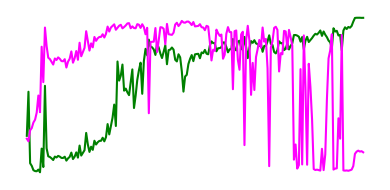

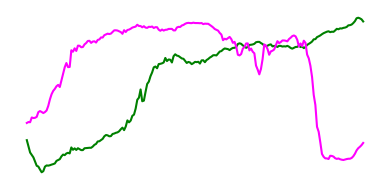

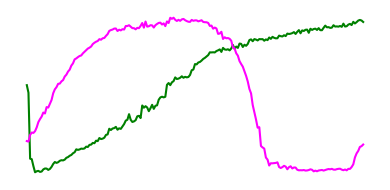

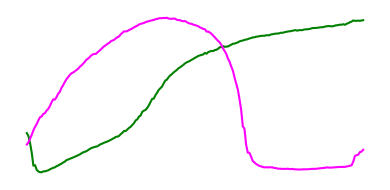

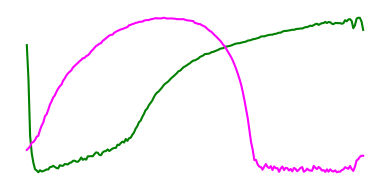

In [20]:
mod = "bf"
idx = 25


for head in good_heads:
    fig, ax1 = plt.subplots(1, 1, figsize=(4, 2), sharey=True)

    ax1.plot(data[mod][head][idx][:, 0], label=f"{head}", color="green", alpha=1)
    ax1.plot(data[mod][head][idx][:, 1], label=f"{head}", color="magenta", alpha=1)
    #ax1.grid('off')
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.axis('off')
    plt.savefig(f'{head}_track.png', bbox_inches='tight', dpi=300)
    plt.tight_layout()
    plt.show()

# checkpoints

In [25]:
rows.__len__()

12

In [44]:

columns = ['L_1', 'L_{1, FUCCI_1}', 'L_{1, FUCCI_2}', 'R^2', 'DTW', ]
super_columns = {'bf':"Brightfield", 'h2b': "Histone H2B"}

#good_heads = ["mlp", "cnn", "lstm", "xtransformer-causal", "mamba", "xtransformer"]
#models = {key:val for key, val in zip(good_heads, ['Single Frame', 'Causal CNN', 'LSTM', 'Causal Transformer', 'Mamba', 'Transformer'])}

good_heads = ["mlp", "cnn", "mamba", "xtransformer"]
models = {key:val for key, val in zip(good_heads, ['Single Frame', 'Causal CNN', 'Mamba', 'Transformer'])}

In [34]:
from collections import defaultdict
threshold_green, threshold_red = 0.05, 0.05
valid_gt, x_crossings_gt, idx_crossing_gt = find_crossing_points(taus, gt_tracks, tr_green=threshold_green, tr_red=threshold_red, smooth_window=None)
print(len(gt_tracks))
print(len(data[mod]['cnn']))
rows = []
for mod in ['bf', 'h2b']:
    for head in good_heads:
        lengths = [len(track) for track in gt_tracks]
        valid_predicted, _, idx = find_crossing_points(taus, data[mod][head], tr_green=threshold_green, tr_red=threshold_red, smooth_window=None)

        #valid_tracks = (valid_gt == 1) &  (valid_predicted==1)
        #print(valid_tracks.sum())
        track_accuracies = defaultdict(list)
        for i in range(len(lengths)):
            length_i = lengths[i]

            if np.isnan(idx_crossing_gt[i, 0]) or np.isnan(idx_crossing_gt[i, 1]) or \
            np.isnan(idx[i, 0]) or np.isnan(idx[i, 1]):
                continue

            c1_gt, c2_gt = map(int, idx_crossing_gt[i])
            l_gt = np.zeros(length_i, dtype=int)
            l_gt[c1_gt:c2_gt] = 1
            l_gt[c2_gt:] = 2

            c1_pr, c2_pr = map(int, idx[i])
            l_pr = np.zeros(length_i, dtype=int)
            l_pr[c1_pr:c2_pr] = 1
            l_pr[c2_pr:] = 2

            for class_label, name in zip([0, 1, 2], ['G1', 'S', 'G2']):
                true_positive = np.sum((l_gt == class_label) & (l_pr == class_label))
                false_positive = np.sum((l_gt != class_label) & (l_pr == class_label))
                false_negative = np.sum((l_gt == class_label) & (l_pr != class_label))

                precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
                recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0

                #track_accuracies['G1'].append(np.mean((l_gt==0) == (l_pr == 0)))
                #track_accuracies['S'].append(np.mean((l_gt==1) == (l_pr == 1)))
                #track_accuracies['G2'].append(np.mean((l_gt==2) == (l_pr == 2)))
                track_accuracies[name].append(2*(precision*recall)/(precision+recall + 1e-6))

        rows.append([np.nanmean(np.abs(idx - idx_crossing_gt), axis=0)[0], np.nanmean(np.abs(idx - idx_crossing_gt), axis=0)[1], np.mean(track_accuracies['G1']),
                     np.mean(track_accuracies['S']), np.mean(track_accuracies['G2']), np.nanstd(np.abs(idx - idx_crossing_gt), axis=0)])

rows_acc = [r[0:5] for r in rows]
rows_std = [r[-1].tolist() for r in rows]
data_ = pd.concat([pd.DataFrame(rows_acc[:len(rows_acc)//2]), pd.DataFrame(rows_acc[len(rows_acc)//2:])], axis=1)
data_.columns = pd.MultiIndex.from_product([list(super_columns.values()), ['$\Delta t_{G1/S}$', '$\Delta t_{S/G2}$']+  ['$G1$', '$S$', '$G2$']])
data_.index = list(models.values())
delta_cols = pd.MultiIndex.from_product([list(super_columns.values()),['$\Delta t_{G1/S}$', '$\Delta t_{S/G2}$']] )
data_[delta_cols] = data_[delta_cols].map(lambda x: x*5)

#rows_acc = [r[2:5] for r in rows]
#accuracies = pd.concat([pd.DataFrame(rows_acc[:len(rows_acc)//2]), pd.DataFrame(rows_acc[len(rows_acc)//2:])], axis=1)
#accuracies.index=  list(models.values())
#accuracies.columns = pd.MultiIndex.from_product([list(super_columns.values()), ['$G1$', '$S$', '$G2$']])
#
#data_ = pd.concat([data_, accuracies], axis=1)
latex_df = data_.copy()
display(latex_df)
import itertools
std_values = pd.concat([pd.DataFrame(rows_std[:len(rows_acc)//2]), pd.DataFrame(rows_std[len(rows_acc)//2:])], axis=1)
std_values.columns = pd.MultiIndex.from_product([list(super_columns.values()), ['$\Delta t_{G1/S}$', '$\Delta t_{S/G2}$']])
std_values.index =   list(models.values())
std_values = std_values.map(lambda x: x*5)


for col in itertools.product(list(super_columns.values()), ['$\Delta t_{G1/S}$', '$\Delta t_{S/G2}$']):
    min_value = data_[col].min()
    std_val = std_values[col]
    latex_df[col] = data_[col].apply(lambda x: f"\\textbf{{{x:.1f}}}" if x == min_value else f"{x:.1f}")
    #latex_df[col] += std_val.apply(lambda s: f" \\textbf{{± {s:.1f}}}" if s == std_val.min() else f" ± {s:.1f}")

for col in itertools.product(list(super_columns.values()),  ['$G1$', '$S$', '$G2$']):
    min_value = data_[col].max()
    #std_val = std_values[col]
    latex_df[col] = data_[col].apply(lambda x: f"\\textbf{{{x:.2f}}}" if x == min_value else f"{x:.2f}")
    #latex_df[col] += std_val.apply(lambda s: f" \\textbf{{± {s:.1f}}}" if s == std_val.min() else f" ± {s:.1f}")

display(latex_df)
with open("checkpoints_table_fullhead_plusminus.tex", "w") as f:
    f.write(latex_df.to_latex(index=True, escape=False))

358
358


Brightfield                                        \
                   $\Delta t_{G1/S}$ $\Delta t_{S/G2}$      $G1$       $S$   
Single Frame              191.312849        117.877095  0.713256  0.635678   
Causal CNN                146.843575        113.254190  0.780838  0.641600   
LSTM                      102.025140         98.114525  0.846114  0.736398   
Causal Transformer        105.754190        106.871508  0.836084  0.719398   
Mamba                     111.354749        102.430168  0.834966  0.720765   
Transformer                60.125698         57.234637  0.900090  0.850568   

                                   Histone H2B                              \
                        $G2$ $\Delta t_{G1/S}$ $\Delta t_{S/G2}$      $G1$   
Single Frame        0.866716        173.463687        140.285714  0.728022   
Causal CNN          0.858950        158.002793        127.627841  0.742652   
LSTM                0.889053        100.111732         63.711485  0.829220   
Causal Transformer  0.879358        109.231844         62.500000  0.816556   
Mamba               0.889072        107.276536         59.469274  0.820658   
Transformer         0.932086         39.231844         47.549020  0.932861   

                                        
                         $S$      $G2$  
Single Frame        0.637289  0.803478  
Causal CNN          0.676087  0.815231  
LSTM                0.798220  0.921259  
Causal Transformer  0.794228  0.920993  
Mamba               0.799325  0.926210  
Transformer         0.885938  0.941584

Brightfield                                   \
                   $\Delta t_{G1/S}$ $\Delta t_{S/G2}$           $G1$   
Single Frame                   191.3             117.9           0.71   
Causal CNN                     146.8             113.3           0.78   
LSTM                           102.0              98.1           0.85   
Causal Transformer             105.8             106.9           0.84   
Mamba                          111.4             102.4           0.83   
Transformer            \textbf{60.1}     \textbf{57.2}  \textbf{0.90}   

                                                       Histone H2B  \
                              $S$           $G2$ $\Delta t_{G1/S}$   
Single Frame                 0.64           0.87             173.5   
Causal CNN                   0.64           0.86             158.0   
LSTM                         0.74           0.89             100.1   
Causal Transformer           0.72           0.88             109.2   
Mamba                        0.72           0.89             107.3   
Transformer         \textbf{0.85}  \textbf{0.93}     \textbf{39.2}   

                                                                    \
                   $\Delta t_{S/G2}$           $G1$            $S$   
Single Frame                   140.3           0.73           0.64   
Causal CNN                     127.6           0.74           0.68   
LSTM                            63.7           0.83           0.80   
Causal Transformer              62.5           0.82           0.79   
Mamba                           59.5           0.82           0.80   
Transformer            \textbf{47.5}  \textbf{0.93}  \textbf{0.89}   

                                   
                             $G2$  
Single Frame                 0.80  
Causal CNN                   0.82  
LSTM                         0.92  
Causal Transformer           0.92  
Mamba                        0.93  
Transformer         \textbf{0.94}

In [36]:
sel_metrics = ['$\Delta t_{G1/S}$', '$\Delta t_{S/G2}$']+  ['$G1$', '$S$', '$G2$']
new_columns = pd.MultiIndex.from_product([list(super_columns.values())[:1], sel_metrics])
latex_df_sel = latex_df.loc[[models[name] for name in ["mlp", "cnn", "mamba", "xtransformer"]],:][new_columns]
display(latex_df_sel)
with open("table2_final_bf.tex", "w") as f:
    f.write(latex_df_sel.to_latex(index=True, escape=False))

Brightfield                                   \
             $\Delta t_{G1/S}$ $\Delta t_{S/G2}$           $G1$   
Single Frame             191.3             117.9           0.71   
Causal CNN               146.8             113.3           0.78   
Mamba                    111.4             102.4           0.83   
Transformer      \textbf{60.1}     \textbf{57.2}  \textbf{0.90}   

                                            
                        $S$           $G2$  
Single Frame           0.64           0.87  
Causal CNN             0.64           0.86  
Mamba                  0.72           0.89  
Transformer   \textbf{0.85}  \textbf{0.93}

In [20]:

threshold_green, threshold_red = 0.05, 0.05
x_crossings_gt, idx_crossing_gt = find_crossing_points(taus, gt_tracks, tr_green=threshold_green,tr_red=threshold_red, smooth_window=None)

rows = []
for mod in ['bf', 'h2b']:
    for head in good_heads:
        _, idx = find_crossing_points(taus, data[mod][head], tr_green=threshold_green,tr_red=threshold_red, smooth_window=None)
        rows.append(np.nanmean(np.abs(idx - idx_crossing_gt), axis=0).tolist())

data_ = pd.concat([pd.DataFrame(rows[:len(rows)//2]), pd.DataFrame(rows[len(rows)//2:])], axis=1)
data_.columns = pd.MultiIndex.from_product([list(super_columns.values()), ['$\delta t_{G1/S}$', '$\delta t_{S/G2}$']])
data_.index =list( models.values() )
data_ = data_.map(lambda x: x*5)

latex_df = data_.copy()
import itertools
for col in itertools.product(list(super_columns.values()), ['$\delta t_{G1/S}$', '$\delta t_{S/G2}$']):
    min_value = data_[col].min()
    latex_df[col] = data_[col].apply(
        lambda x: f"\\textbf{{{x:.1f}}}" if x == min_value else f"{x:.1f}"
    )
display(latex_df)
latex_df.to_latex(index=True, escape=False)
# Save the LaTeX table to a file
with open("table2.tex", "w") as f:
    f.write(latex_df.to_latex(index=True, escape=False))

Brightfield                         Histone H2B  \
                   $\delta t_{G1/S}$ $\delta t_{S/G2}$ $\delta t_{G1/S}$   
Single Frame                   191.3             117.9             173.5   
Causal CNN                     146.8             113.3             158.0   
LSTM                           102.0              98.1             100.1   
Causal Transformer             105.8             106.9             109.2   
Mamba                          111.4             102.4             107.3   
Transformer            \textbf{60.1}     \textbf{57.2}     \textbf{39.2}   

                                      
                   $\delta t_{S/G2}$  
Single Frame                   140.3  
Causal CNN                     127.6  
LSTM                            63.7  
Causal Transformer              62.5  
Mamba                           59.5  
Transformer            \textbf{47.5}

In [62]:

threshold_green, threshold_red = 0.03, 0.005
idx_crossing_gt, idx_crossing_gt = find_crossing_points(taus, gt_tracks, tr_green=threshold_green,tr_red=threshold_red, smooth_window=None)

rows = []
for mod in ['bf', 'h2b']:
    for head in good_heads:
        _, idx = find_crossing_points(taus, data[mod][head], tr_green=threshold_green,tr_red=threshold_red, smooth_window=None)
        rows.append(np.nanmean(np.abs(idx - idx_crossing_gt), axis=0).tolist())
        plt.figure(figsize=(10, 5))
        for i in range(1):
            plt.suptitle("GT")
            plt.subplot(1, 2, 1)
            plt.title(f"log signal")
            plt.plot(gt_tracks[i][:, 0], color="green")
            plt.plot(gt_tracks[i][:, 1], color="magenta")
            plt.axvline(idx_crossing_gt[i, 0], color="black", linestyle="--")
            #plt.axvline(idx_crossing_gt[i, 1], color="black", linestyle="--")
            plt.close()

            plt.figure(figsize=(10, 5))
            plt.title(f"Prediction {head} {mod}")
            plt.plot(data[mod][head][i][:, 0], color="green")
            plt.plot(data[mod][head][i][:, 1], color="magenta")
            plt.axvline(idx[i, 0], color="black", linestyle="--")
            #plt.axvline(idx[i, 1], color="black", linestyle="--")
            plt.close()


In [63]:

columns = ['L_1', 'L_{1, FUCCI_1}', 'L_{1, FUCCI_2}', 'R^2', 'DTW', ]
super_columns = {'bf':"Brightfield", 'h2b': "Histone H2B"}
models = {key:val for key, val in zip(good_heads, ['Single Frame', 'Causal CNN', 'Mamba', 'Transformer'])}

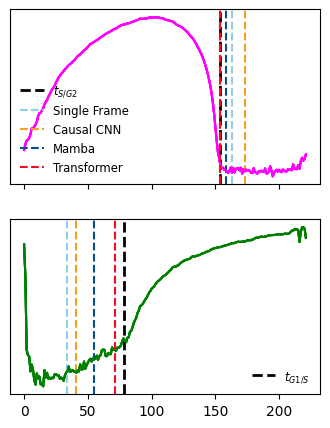

In [90]:

threshold_green, threshold_red = 0.03, 0.005
idx_crossing_gt, idx_crossing_gt = find_crossing_points(taus, gt_tracks, tr_green=threshold_green,tr_red=threshold_red, smooth_window=None)

rows = []
for mod in ['bf']:
    i = 26
    fig, ax = plt.subplots(2, 1, figsize=(4, 5), sharex=True, sharey=True)
    ax[0].axvline(idx_crossing_gt[i, 1], color="black", linestyle="--", alpha=1, label="$t_{S/G2}$", lw=2)
    ax[1].axvline(idx_crossing_gt[i, 0], color="black", linestyle="--", alpha=1, label="$t_{G1/S}$", lw=2)
    ax[1].legend(frameon=False, fontsize="small", loc='lower right')
    ax[0].set_yticks([])
    ax[1].set_yticks([])
    for color, head in zip( ['#95cee1',"#f19e21", "#0a4d8b",    "#f60b20",], good_heads):
        _, idx = find_crossing_points(taus, data[mod][head], tr_green=threshold_green,tr_red=threshold_red, smooth_window=None)
        rows.append(np.nanmean(np.abs(idx - idx_crossing_gt), axis=0).tolist())
        ax[0].plot(gt_tracks[i][:, 1], color="magenta")
        ax[0].axvline(idx[i, 1], color=color, linestyle="--", label = models[head])
        ax[1].plot(gt_tracks[i][:, 0], color="green")
        ax[1].axvline(idx[i, 0], color=color, linestyle="--", label = models[head])
    ax[0].legend(frameon=False, fontsize="small", loc='lower left')
    plt.show()

In [35]:
pd.DataFrame(rows)

,0,1
0,38.262570,23.575419
1,29.368715,22.650838
2,22.270950,20.486034
3,12.025140,11.446927
4,34.692737,28.057143
5,31.600559,25.525568
6,21.455307,11.893855
7,7.846369,9.509804


In [ ]:

threshold_green, threshold_red = 0.1, 0.05
x_crossings_gt, idx_crossing_gt = find_crossing_points(taus, gt_tracks, tr_green=threshold_green,tr_red=threshold_red, smooth_window=10)

rows = []
for mod in ['bf', 'h2b']:
    for head in good_heads:
        _, idx = find_crossing_points(taus, data[mod][head], tr_green=threshold_green,tr_red=threshold_red, smooth_window=10)
        rows.append((idx - idx_crossing_gt).mean(axis=0).tolist())



plt.figure(figsize=(10, 5))
plt.suptitle("GT")

idx = np.random.randint(0, n_tracks)

plt.subplot(1, 2, 1)
plt.title(f"log signal")
plt.plot(taus[idx], gt_tracks[idx][:, 0], color="green")
plt.plot(taus[idx], gt_tracks[idx][:, 1], color="red")

fuc = inverse_log_min_max(gt_tracks[idx], eps=0.01, log_base=np.e)

plt.subplot(1, 2, 2)
plt.title(f"linear signal")
plt.plot(taus[idx], fuc[:, 0], color="green")
plt.plot(taus[idx], fuc[:, 1], color="red")


plt.axvline(x_crossings_gt[idx, 0], color="black", linestyle="--")
plt.axvline(x_crossings_gt[idx, 1], color="black", linestyle="--")
plt.show()


plt.figure(figsize=(10, 5))
plt.suptitle(f"prediction {head} {modality}")

plt.subplot(1, 2, 1)
plt.title(f"log signal")
plt.plot(taus[idx], tracks[idx][:, 0], color="green")
plt.plot(taus[idx], tracks[idx][:, 1], color="red")

fuc = inverse_log_min_max(tracks[idx], eps=0.01, log_base=np.e)

plt.subplot(1, 2, 2)
plt.title(f"linear signal")
plt.plot(taus[idx], fuc[:, 0], color="green")
plt.plot(taus[idx], fuc[:, 1], color="red")


plt.axvline(x_crossings[idx, 0], color="black", linestyle="--")
plt.axvline(x_crossings[idx, 1], color="black", linestyle="--")

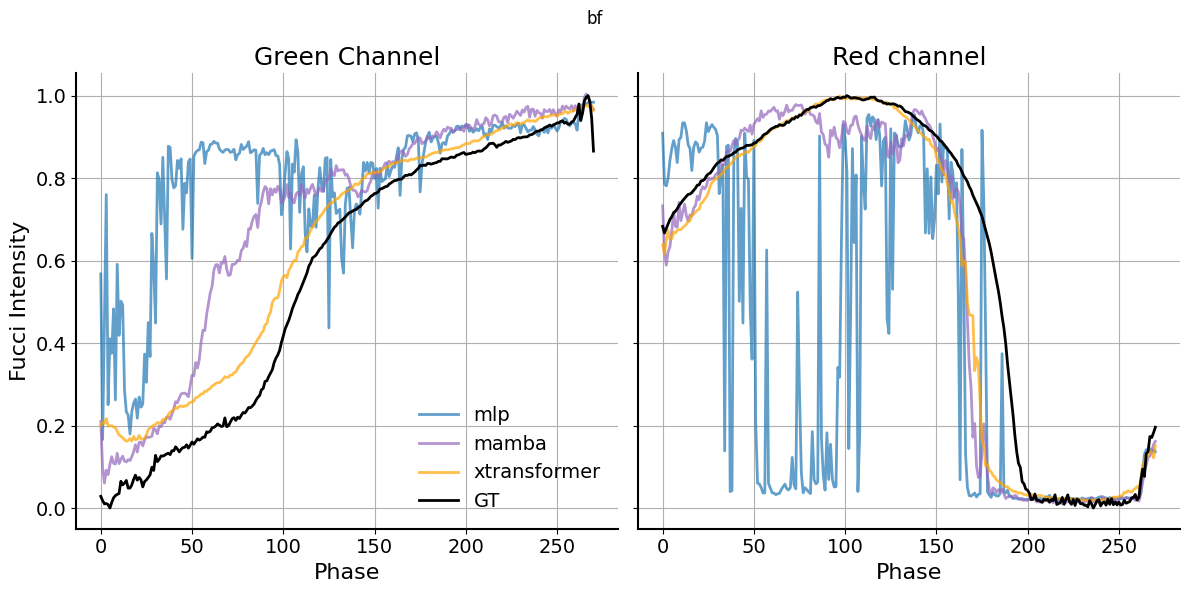

In [12]:
# choose modality here
mod = "bf"
# choose track here
idx = 119
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
plt.suptitle(mod)

# Left subplot for errors_g_averaged
ax1.set_title("Green Channel")
ax1.set_xlabel("Phase")
ax1.set_ylabel("Fucci Intensity")


for head in good_heads:
    ax1.plot(data[mod][head][idx][:, 0], label=f"{head}", color=head_colors[head], alpha=0.7)

ax1.plot(gt_tracks[idx][:, 0], label="GT", color="black")
ax1.legend()
ax1.grid()

# Right subplot for errors_r_averaged
ax2.set_title("Red channel")
ax2.set_xlabel("Phase")

for head in good_heads:
    ax2.plot(data[mod][head][idx][:, 1], label=f"{head}", color=head_colors[head], alpha=0.7)

ax2.plot(gt_tracks[idx][:, 1], label="GT", color="black")

# ax2.legend()
ax2.grid()

# Ensure tight layout and consistent y-axis scaling
plt.tight_layout()

# save the figure
# plt.savefig(f"../plots/av_error/profile_{mod}.pdf")
plt.show()

# Example Predictions

In [173]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys
sys.path.append("..")
from helper_fn import *
current_dir = ""
relative_path = "../data"
path = os.path.join(current_dir, relative_path)
data_path = os.path.join(path, "test/")
data_drug_path = os.path.join(path, "test_drug/")
gt_path = os.path.join(path, "GT/")
gt_drug_path = os.path.join(path, "GT_drug/labels/")

drug = False

if drug:
    data_path_ = data_drug_path
    gt_path_ = gt_drug_path
else:
    data_path_ = data_path
    gt_path_ = gt_path

gt_tracks = []
taus = []
for i, fn in enumerate(os.listdir(gt_path_)):
    track = np.load(os.path.join(gt_path_, fn)).squeeze().T
    tau = np.linspace(0, 1, track.shape[0])
    gt_tracks.append(track)
    taus.append(tau)
track_lengths = [track.shape[0] for track in gt_tracks]
modalities = ["bf", "h2b"]
data = {}
for mod in modalities:
    data[mod] = {}
    for head in heads:
        # loading the dataset
        tracks = get_data(data_path_, mod, head)
        data[mod][head] = tracks

columns = ['$L_{1, FUCCI_1}$', '$L_{1, FUCCI_2}$', '$R^2_{FUCCI_1}$', '$R^2_{FUCCI_2}$', '$L_1$', '$R^2$', '$DTW$', ]
super_columns = {'bf':"Brightfield", 'h2b': "Histone H2B"}
good_heads = ["mlp", "cnn", "mamba", "xtransformer"]
models = {key:val for key, val in zip(good_heads, ['Single Frame', 'CNN', 'Mamba', 'Transformer'])}
models_inv = {key:val for key, val in zip(['Single Frame', 'CNN', 'Mamba', 'Transformer'], good_heads)}
data['bf']['GT'] = gt_tracks
data['h2b']['GT'] = gt_tracks

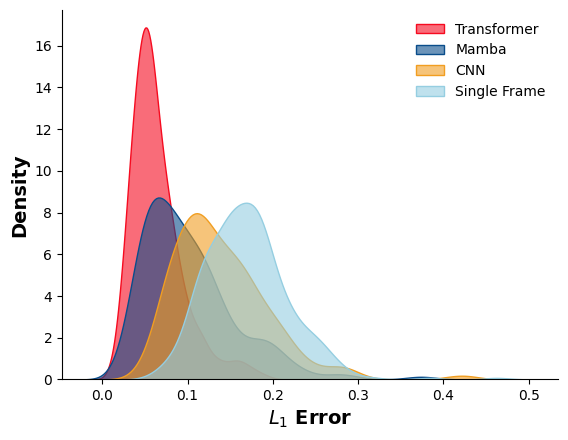

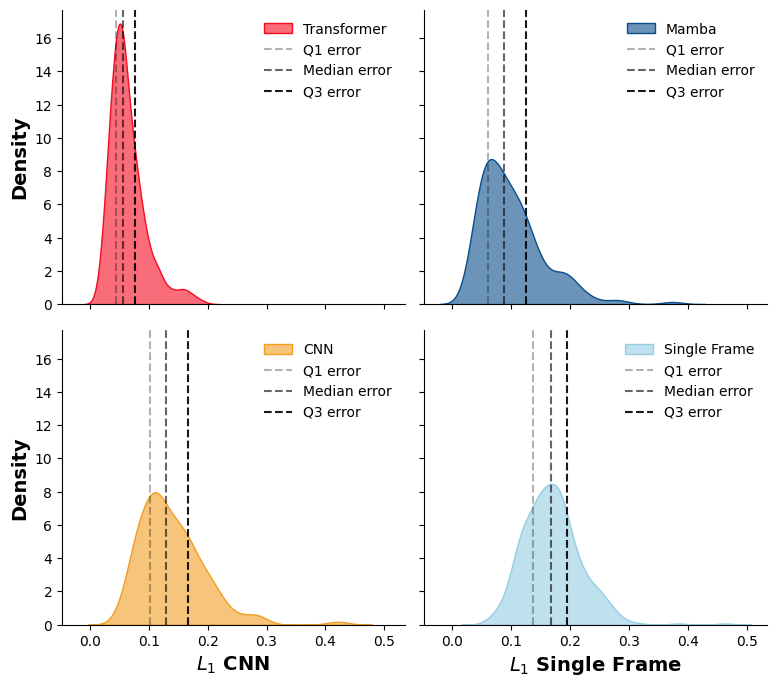

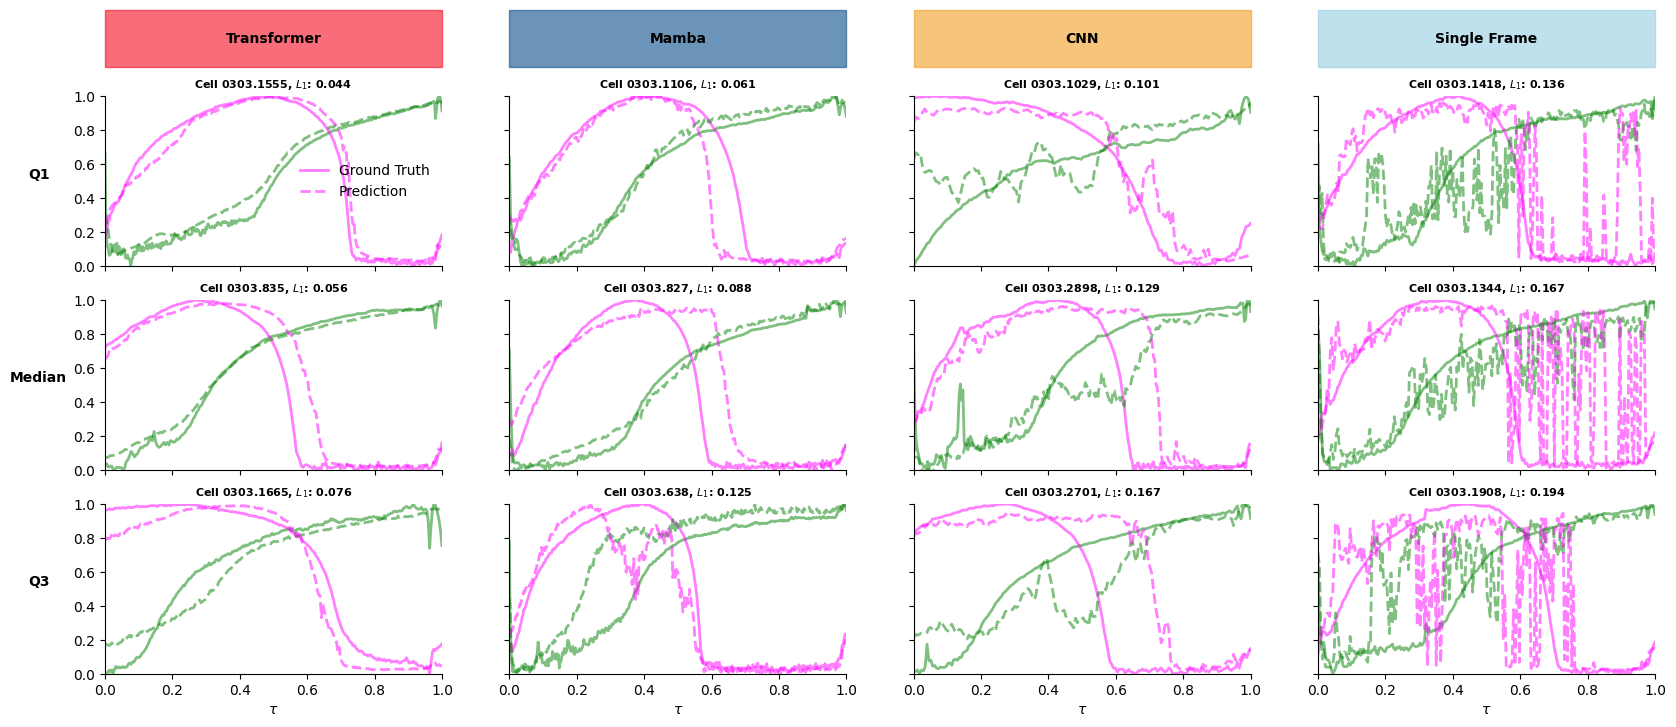

In [187]:
from collections import defaultdict
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
import seaborn as sns
import matplotlib as mpl
import warnings
from matplotlib.patches import Rectangle
from matplotlib.transforms import Bbox
warnings.filterwarnings("ignore")
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
#"#0a4d8b"
head_colors = ['#95cee1',"#f19e21", "#0a4d8b",    "#f60b20",][::-1]
l1 = {}
#fig, ax = plt.subplots(4, 4, figsize = (16, 10))
for head in good_heads:
    l1[head] = np.array([mean_absolute_error(gt_tracks[idx], data["bf"][head][idx]) for idx in range(len(gt_tracks))])
track_ids = [track[:-4] for track in os.listdir(gt_path_)]

l1_df = pd.DataFrame(l1)
l1_df.columns = columns=[models[key] for key in l1]

for i, column in enumerate(l1_df.columns.tolist()[::-1]):
    sns.kdeplot(l1_df[column], fill=True, color=head_colors[i % len(head_colors)], linewidth=1, alpha=.6, label=column)
    
plt.legend(frameon=False)
plt.xlabel('$L_1$ Error', fontsize = 14, fontweight = 'bold')
plt.ylabel('Density', fontsize = 14, fontweight='bold')
plt.savefig('l1_density_errors_bf.png', bbox_inches='tight', dpi=300)
plt.show()


fig, ax = plt.subplots(2, 2, figsize = (8, 7), sharex=True, sharey=True)

ax = ax.flatten()
# plot histograms separately
quantile_indexes = defaultdict(list)

for i, column in enumerate(l1_df.columns.tolist()[::-1]):
    sns.kdeplot(l1_df[column], fill=True, color=head_colors[i % len(head_colors)], linewidth=1, alpha=.6, label=column, ax = ax[i])
    for qname, quantile, alpha, style in zip(['Q1', 'Median', 'Q3'], [0.25, 0.5, 0.75], [0.3, 0.6, 0.9], ["dashed", 'dashed', "dashed"]):
        qval = np.quantile(l1_df[column], q=quantile)
        #print(column, qname, qval)
        closest_index = (l1_df[column] - qval).abs().idxmin()
        quantile_indexes[column].append( closest_index )
        ax[i].axvline(qval, color='k', alpha=alpha, ls=style, label=qname + " error")
    
    ax[i].legend(frameon=False)


    ax[i].set_xlabel(f'$L_1$ {column}', fontsize = 14, fontweight = 'bold')
    ax[i].set_ylabel("Density", fontsize = 14, fontweight = 'bold')

plt.tight_layout()
plt.savefig('quantile_error_bf.png', dpi=300, bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(3, 4, figsize = (20, 7.5), sharex=True, sharey=True)

for hdx, head in enumerate(list(quantile_indexes.keys())):
    b = Bbox.union([ax[i, hdx].get_position() for i in range(3)])
    r = Rectangle((b.x0,  b.y0 + 1.05*b.height), b.width,  b.y0 + 1.15*b.height - (b.y0 + 1.05*b.height), transform=fig.transFigure, fc=head_colors[hdx], alpha=0.6, ec=head_colors[hdx], lw=1)
    fig.add_artist(r)
    fig.text(b.x0 + b.width / 2, b.y0 + 1.1*b.height, head, fontweight='bold', ha='center', va='center')

    for qdx, (qname, idx) in enumerate(zip(['Q1', 'Median', 'Q3'], quantile_indexes[head])):
        l1_val = l1_df.loc[idx, head]
        ax[qdx, hdx].set_title(f'Cell {track_ids[idx]}, $L_1$: {round(l1_val, 3)}', fontweight='bold', fontsize=8)
        ax[qdx, 0].set_ylabel(f'{qname}', fontweight='bold', rotation=0, labelpad=25)
        track_length = len(gt_tracks[idx])
        ax[qdx, hdx].set_xlim(0, 1)
        ax[qdx, hdx].set_ylim(0, 1)
        #print("live L1", mean_absolute_error(gt_tracks[idx], data['bf'][models_inv[head]][idx]))
        #print(models_inv[head], head)
        ax[qdx, hdx].plot(np.linspace(0, 1, track_length), gt_tracks[idx][:, 0], color="green", lw=2, alpha=0.5)
        ax[qdx, hdx].plot(np.linspace(0, 1, track_length), gt_tracks[idx][:, 1], color="magenta", lw=2, alpha=0.5, label='Ground Truth')
        ax[qdx, hdx].plot(np.linspace(0, 1, track_length), data['bf'][models_inv[head]][idx][:, 0], color="green", lw=2, alpha=0.5, ls='dashed')
        ax[qdx, hdx].plot(np.linspace(0, 1, track_length), data['bf'][models_inv[head]][idx][:, 1], color="magenta", lw=2, alpha=0.5, ls='dashed', label='Prediction')
    ax[-1, hdx].set_xlabel("$\\tau$", fontweight='bold')

ax[0, 0].legend(frameon=False, )

plt.savefig('more_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# choose modality here
mod = "bf"
# choose track here
idx = 119
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
plt.suptitle(mod)

# Left subplot for errors_g_averaged
ax1.set_title("Green Channel")
ax1.set_xlabel("Phase")
ax1.set_ylabel("Fucci Intensity")


for head in good_heads:
    ax1.plot(data[mod][head][idx][:, 0], label=f"{head}", color=head_colors[head], alpha=0.7)

ax1.plot(gt_tracks[idx][:, 0], label="GT", color="black")
ax1.legend()
ax1.grid()

# Right subplot for errors_r_averaged
ax2.set_title("Red channel")
ax2.set_xlabel("Phase")

for head in good_heads:
    ax2.plot(data[mod][head][idx][:, 1], label=f"{head}", color=head_colors[head], alpha=0.7)

ax2.plot(gt_tracks[idx][:, 1], label="GT", color="black")

# ax2.legend()
ax2.grid()

# Ensure tight layout and consistent y-axis scaling
plt.tight_layout()

# save the figure
# plt.savefig(f"../plots/av_error/profile_{mod}.pdf")
plt.show()